In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is available
Using GPU: NVIDIA GeForce GTX 1070


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
import matplotlib.pyplot as plt

BATCH_SIZE = 20
NUM_CLASSES = 43
IMAGE_SIZE = (224, 224)
LEARNING_RATE = 0.00005
NUM_EPOCHS = 10

train_dir = "F:/DATASET/TRAFFIC SIGNS PICKLE DATA 0 224x224/train"
valid_dir = "F:/DATASET/TRAFFIC SIGNS PICKLE DATA 0 224x224/valid"
test_dir = "F:/DATASET/TRAFFIC SIGNS PICKLE DATA 0 224x224/test"

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=NUM_CLASSES)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()

# Optimizer with gradual learning rate reduction
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR by 10x every 5 epochs

# Mixed precision training setup
scaler = GradScaler()

# Training loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS):
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)

        # Validation
        model.eval()
        with torch.no_grad():
            val_correct = 0
            val_total = 0
            val_running_loss = 0.0
            for val_inputs, val_labels in valid_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

            valid_loss = val_running_loss / len(valid_loader)
            valid_accuracy = 100 * val_correct / val_total
            valid_losses.append(valid_loss)
            valid_accs.append(valid_accuracy)

            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, '
                  f'Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {valid_loss:.4f}, '
                  f'Validation Accuracy: {valid_accuracy:.2f}%')

        scheduler.step()

    print("Training finished.")
    return train_losses, valid_losses, train_accs, valid_accs

Loaded pretrained weights for efficientnet-b7


In [3]:
# Train the model
train_losses, valid_losses, train_accs, valid_accs = train_model(model, criterion, optimizer, scheduler)

Epoch 1/10, Training Loss: 0.2389, Training Accuracy: 95.15%, Validation Loss: 0.0388, Validation Accuracy: 98.89%


Epoch 2/10, Training Loss: 0.0084, Training Accuracy: 99.81%, Validation Loss: 0.0389, Validation Accuracy: 99.46%


KeyboardInterrupt: 

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 632/632 [16:41<00:00,  1.58s/it]


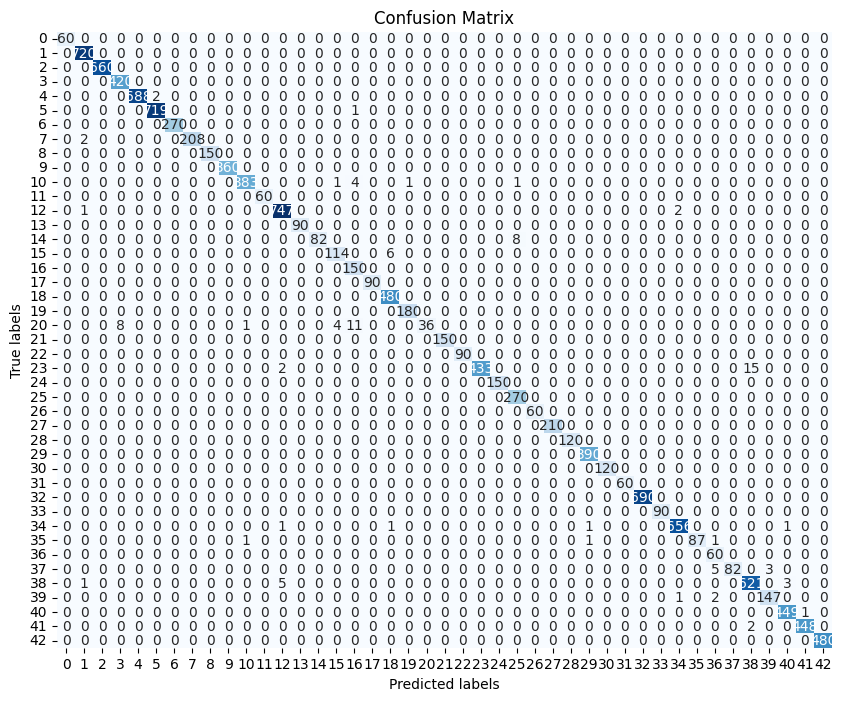

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
          10       1.00      1.00      1.00       660
          11       0.98      1.00      0.99       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      0.99      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00      1.00      1.00       360
          18       0.99      0.98      0.99       390
          19       1.00      1.00      1.00        60
           2       0.99      1.00      0.99       750
          20       1.00      1.00      1.00        90
          21       1.00      0.91      0.95        90
          22       0.96      0.95      0.95       120
          23       0.90      1.00      0.95       150
    

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Calculate classification report
    report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
    print("Classification Report:")
    print(report)
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print("Overall Accuracy:", accuracy)
    
    return cm, report, accuracy

# Evaluate the model
cm, report, accuracy = evaluate_model(model, test_loader)

In [10]:
from skimage.segmentation import mark_boundaries

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


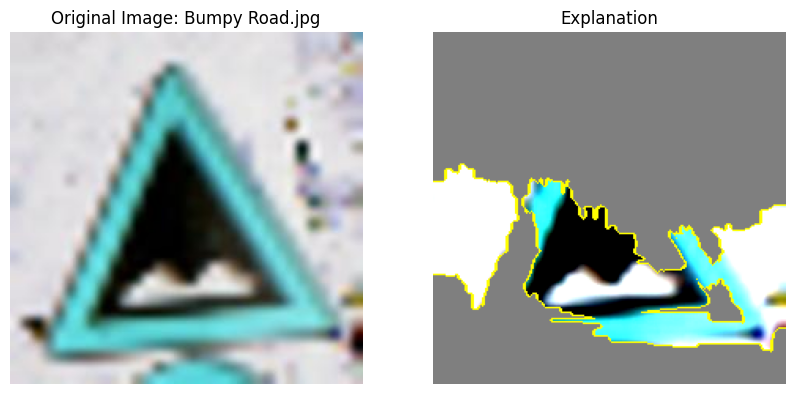

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


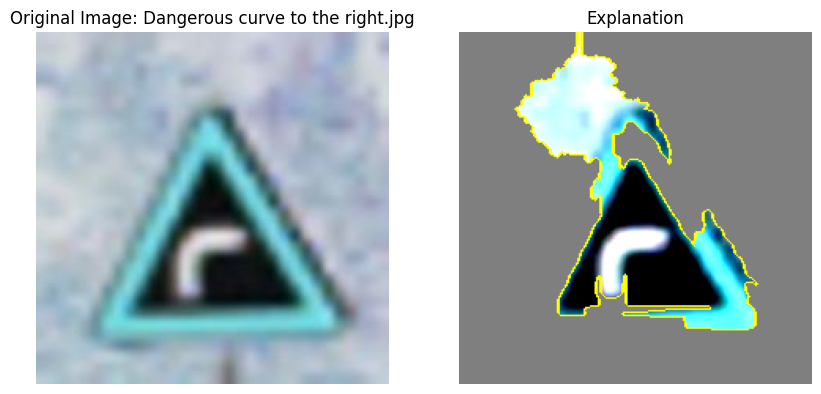

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


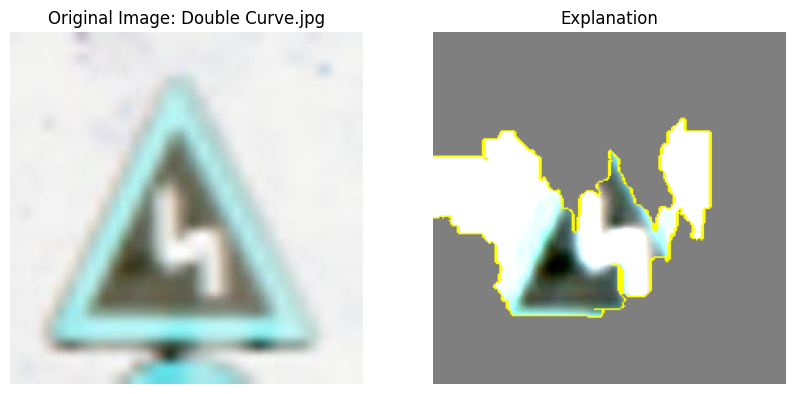

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


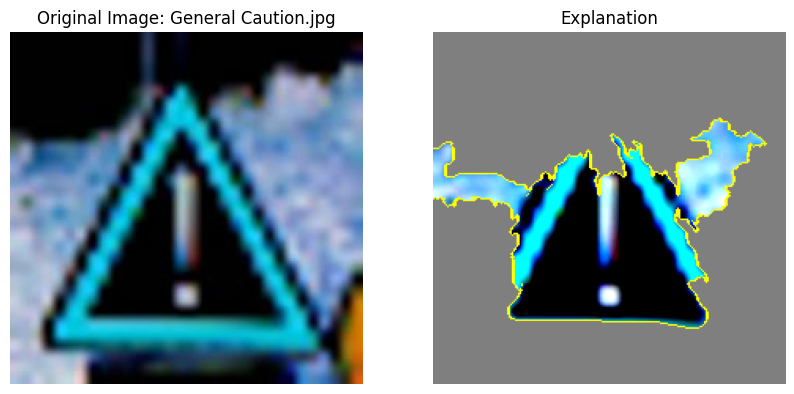

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


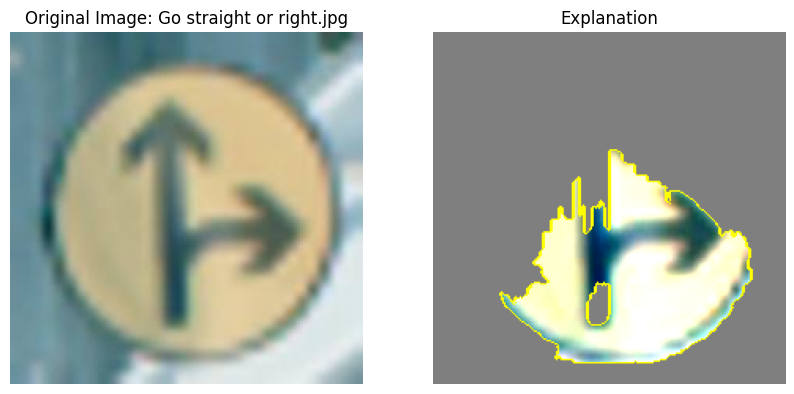

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


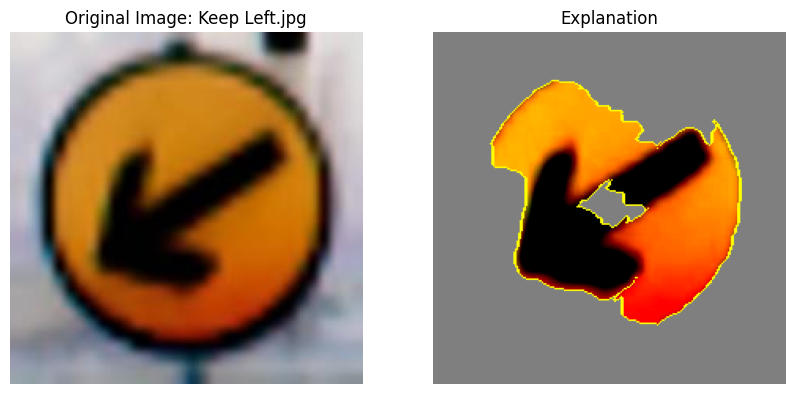

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


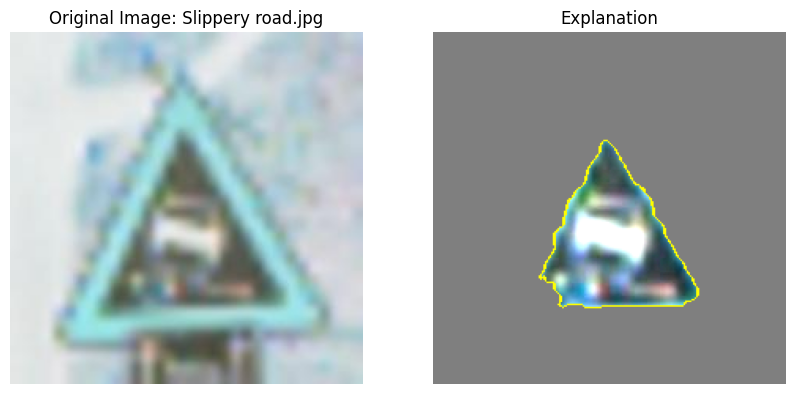

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


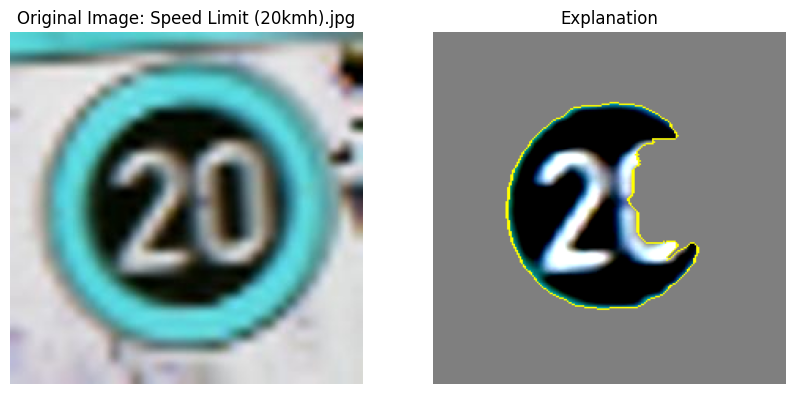

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


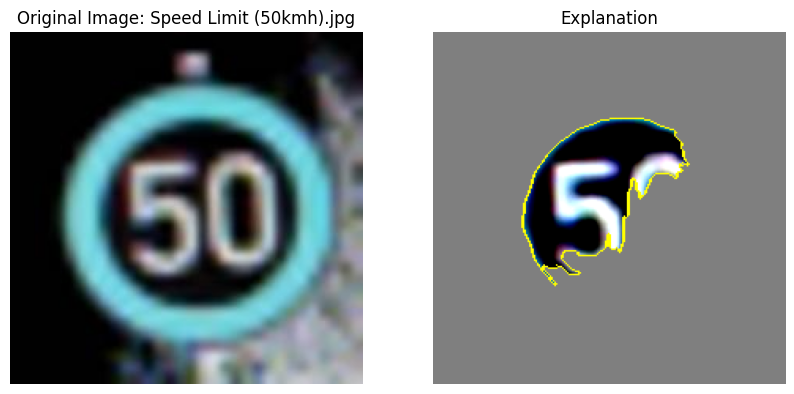

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


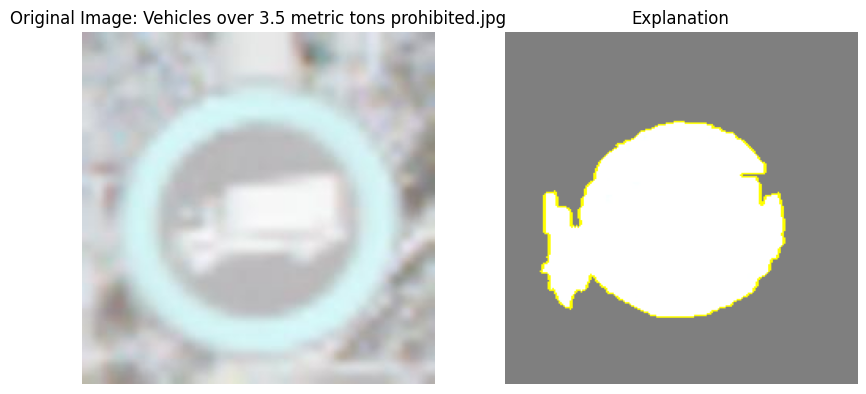

In [11]:
from lime import lime_image
import os
from PIL import Image

# Step 1: Import necessary libraries for LIME

# Step 2: Load images from the directory
xai_samples_dir = "F:/DATASET/XAI SAMPLES"
xai_samples = os.listdir(xai_samples_dir)

# Step 3: Preprocess images
transform = data_transforms['test']  # Use the same transform as the test dataset

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image

# Step 4: Use LIME to generate explanations
def generate_lime_explanations(model, image_path):
    explainer = lime_image.LimeImageExplainer()
    image = load_and_preprocess_image(image_path)
    
    # Explanation for the top prediction
    def predict_fn(images):
        # Ensure images are in the correct format (batch dimension)
        images = np.transpose(images, (0, 3, 1, 2))
        images = torch.tensor(images).float().to(device)
        # Forward pass
        outputs = model(images)
        return outputs.detach().cpu().numpy()
    
    explanation = explainer.explain_instance(np.transpose(image.numpy(), (1, 2, 0)), predict_fn, top_labels=1, hide_color=0, num_samples=1000)
    
    return explanation


# Step 5: Visualize original images with explanations
for image_name in xai_samples:
    image_path = os.path.join(xai_samples_dir, image_name)
    explanation = generate_lime_explanations(model, image_path)
    
    # Visualization
    plt.figure(figsize=(10, 5))
    
    # Original image
    plt.subplot(1, 2, 1)
    original_image = Image.open(image_path)
    plt.imshow(original_image)
    plt.title(f"Original Image: {image_name}")
    plt.axis('off')
    
    # Explanation
    plt.subplot(1, 2, 2)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title("Explanation")
    plt.axis('off')
    
    plt.show()